In [1]:
from api_somo import DataFetcher, fetch_qf 
import logging

# Setting up logging for the main script
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/filter-serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date":"2009-01-01",
    "end_date":"2009-12-31"
    }

try:
    # 1. Fetch and process the data
    red_mpomm_serie = DataFetcher.fetch_and_process_data(api_url, params)

    if red_mpomm_serie.empty:
        raise ValueError("The historical series is empty.")

    # Additional processing with the historical series
    logger.info(f"Fetched historical series: {red_mpomm_serie.head(0)}")

except Exception as e:
    logger.error(f"Error fetching historical series: {e}")


display(red_mpomm_serie)

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/filter-serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2009-01-01', 'end_date': '2009-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag', 'latitude', 'longitude']
INFO:api_somo:Columns after renaming: ['timestamp', 'value', 'qf', 'latitude', 'longitude']
INFO:api_somo:Timestamp conversion and indexing complete.
INFO:__main__:Fetched historical series: Empty DataFrame
Columns: [value, qf, latitude, longitude]
Index: []


,value,qf,latitude,longitude
timestamp,,,,
2009-02-01 05:10:00+00:00,0.0,1,1.82011,-78.72871
2009-02-01 05:20:00+00:00,0.0,1,1.82011,-78.72871
2009-02-01 05:30:00+00:00,0.0,1,1.82011,-78.72871
2009-02-01 05:40:00+00:00,0.0,1,1.82011,-78.72871
2009-02-01 05:50:00+00:00,0.0,1,1.82011,-78.72871
...,...,...,...,...
2009-12-31 04:20:00+00:00,0.0,1,1.82011,-78.72871
2009-12-31 04:30:00+00:00,0.0,1,1.82011,-78.72871
2009-12-31 04:40:00+00:00,0.0,1,1.82011,-78.72871


In [2]:
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, OperationFailure
import pandas as pd

try:
    # Conexión a MongoDB
    print("Intentando conectar a MongoDB...")
    client = MongoClient('localhost', 27017)  # Cambia los parámetros si es necesario
    print("Conexión a MongoDB exitosa.")

    # Selecciona la base de datos y la colección
    db = client['CHIRPS']
    collection = db['sensor_data']

    print(client['EVC-SOMMO'].list_collection_names())  # Lista las colecciones de la base de datos


    # Consulta para obtener todos los documentos de la colección
    print("Obteniendo documentos de la colección...")
    data = collection.find()  # Esto devuelve un cursor iterable

    # Convertir el cursor a una lista
    data_list = list(data)

    if not data_list:
        print("No se encontraron documentos.")
    else:
        # Crear listas para almacenar los datos extraídos
        points = []
        timestamps = []

        # Recorrer los documentos y extraer los datos relevantes
        for document in data_list:
            timestamp = document.get('timestamp')  # Extrae el timestamp
            points_data = document.get('point_data', [])  # Extrae el array de puntos

            for point in points_data:
                point_dict = {
                    'point_id': point.get('point_id'),
                    'latitude': point.get('latitude'),
                    'longitude': point.get('longitude'),
                    'value': point.get('value'),
                    'timestamp': timestamp  # Incluir timestamp para cada punto
                }
                points.append(point_dict)

        # Convertir los puntos a un DataFrame
        print(f"Se encontraron {len(points)} puntos. Convirtiendo a DataFrame...")
        df = pd.DataFrame(points)

        # Si la colección tiene un campo '_id', lo eliminamos para evitar problemas
        if '_id' in df.columns:
            df = df.drop(columns=['_id'])
        
        # Filtrar los puntos deseados
        selected_points = ['point_6', 'point_10', 'point_12']
        df = df[df['point_id'].isin(selected_points)]

        # Mostrar las primeras filas del DataFrame
        print("DataFrame creado con éxito:")
        display(df.head(5))

except ConnectionFailure as e:
    print(f"Error al conectar con MongoDB: {e}")
except OperationFailure as e:
    print(f"Error en la operación de MongoDB: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")


Intentando conectar a MongoDB...
Conexión a MongoDB exitosa.
[]
Obteniendo documentos de la colección...
Se encontraron 60996 puntos. Convirtiendo a DataFrame...
DataFrame creado con éxito:


,point_id,latitude,longitude,value,timestamp
5,point_6,1.774998,-78.725006,0.000000,2009-02-01
9,point_10,1.824997,-78.725006,0.000000,2009-02-01
11,point_12,1.824997,-78.775000,0.000000,2009-02-01
17,point_6,1.774998,-78.725006,0.000000,2009-02-02
21,point_10,1.824997,-78.725006,12.457714,2009-02-02


In [3]:
from utils.utils import reshample_time_serie
import numpy as np
serie_resample=reshample_time_serie(red_mpomm_serie, nueva_frecuencia='D', metodo='sum')
display(serie_resample.columns)
# Aplicar la condición para reemplazar 'value' con NaN si 'qf' no es 1
serie_resample['value'] = serie_resample['value'].where(serie_resample['qf'] == 1, np.nan)
serie_resample

import pandas as pd

dataset = serie_resample['value'].to_frame()

display(dataset.isnull().sum())

# Mostrar el resultado
display(dataset)


Index(['value', 'qf', 'latitude', 'longitude'], dtype='object')

value    1
dtype: int64

,value
timestamp,
2009-02-01,0.0
2009-02-02,0.7
2009-02-03,23.3
2009-02-04,0.0
2009-02-05,0.0
...,...
2009-12-27,53.3
2009-12-28,0.3
2009-12-29,0.0


In [4]:
import pandas as pd

# Suponiendo que df es tu dataset original
df['timestamp'] = pd.to_datetime(df['timestamp'])  # Asegurar que sea datetime

# Crear la tabla pivotante con fecha como índice y cada punto como columna
df_pivot = df.pivot_table(index='timestamp', columns='point_id', values='value')

# Mostrar el DataFrame resultante
display(df_pivot)


point_id,point_10,point_12,point_6
timestamp,,,
2009-02-01,0.000000,0.000000,0.000000
2009-02-02,12.457714,16.109703,0.000000
2009-02-03,12.457714,16.109703,29.260645
2009-02-04,0.000000,0.000000,0.000000
2009-02-05,0.000000,0.000000,0.000000
...,...,...,...
2022-12-28,0.000000,0.000000,7.627149
2022-12-29,0.000000,0.000000,0.000000
2022-12-30,0.000000,0.000000,11.136356


In [5]:
# Reemplazar los valores mayores a 500 por NaN
df_pivot = df_pivot.mask(df_pivot > 500)
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
df_pivot.isnull().sum()


point_id
point_10    1
point_12    0
point_6     6
dtype: int64

In [6]:
# Eliminar columnas duplicadas en `df_pivot` que ya existen en `dataset`
df_pivot = df_pivot.loc[:, ~df_pivot.columns.isin(dataset.columns)]

# Intentar unir los DataFrames nuevamente
dataset = dataset.join(df_pivot, how='inner')

display(dataset.shape)
display(dataset.head())


(0, 4)

,value,point_10,point_12,point_6
timestamp,,,,


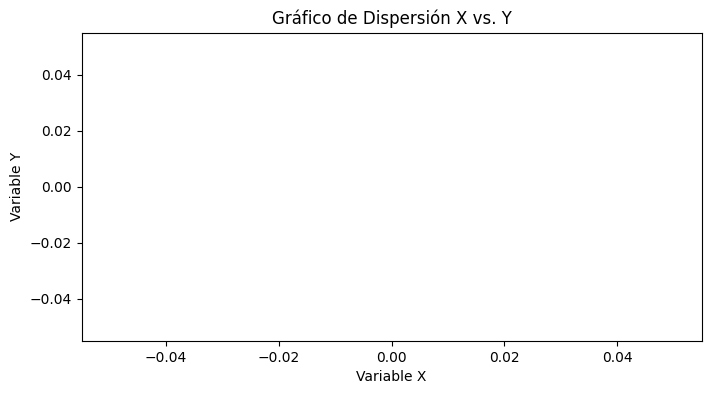

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.scatter(range(len(dataset)), dataset, alpha=0.5)
plt.xlabel("Variable X")
plt.ylabel("Variable Y")
plt.title("Gráfico de Dispersión X vs. Y")
plt.show()


In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(value)
print(f"Shapiro-Wilk test: p = {p}")

if p < 0.05:
    print("La distribución NO es normal (puede necesitar transformación).")
else:
    print("La distribución es aproximadamente normal.")


NameError: name 'red_mpomm_serie' is not defined

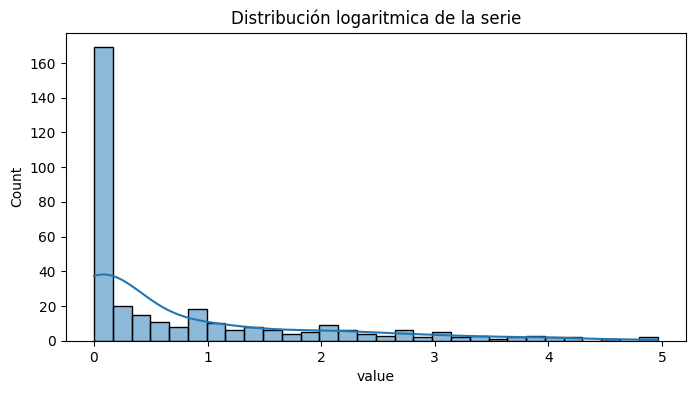

In [8]:
import numpy as np

value_log = np.log1p(value)  # log(1 + x) para evitar problemas con valores cercanos a 0

plt.figure(figsize=(8, 4))
sns.histplot(value_log, bins=30, kde=True)
plt.title("Distribución logaritmica de la serie")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

# Transformación logarítmica
value_log = np.log1p(dataset_model)  # log(1 + x) para evitar problemas con valores cercanos a 0

# Crear un DataFrame para Plotly
value_log_df = pd.DataFrame(value_log, columns=["point_10", "point_6", "value"])

# Crear histogramas para cada variable
fig = px.histogram(
    value_log_df.melt(var_name="Variable", value_name="Value"),
    x="Value",
    color="Variable",
    marginal="box",  # Añade un diagrama de caja como referencia
    nbins=30,
    title="Distribución de las variables transformadas logarítmicamente"
)

# Mostrar gráfico
fig.update_layout(
    xaxis_title="Valor (log1p)",
    yaxis_title="Frecuencia",
    template="plotly_white"
)
fig.show()
